Carga de archivo y librerías

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('incident_event_log.csv', index_col=0)

Exploración inicial de datos


In [5]:
data.shape, data.head(10), data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141712 entries, INC0000045 to INC0121064
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   incident_state           141712 non-null  object
 1   active                   141712 non-null  bool  
 2   reassignment_count       141712 non-null  int64 
 3   reopen_count             141712 non-null  int64 
 4   sys_mod_count            141712 non-null  int64 
 5   made_sla                 141712 non-null  bool  
 6   caller_id                141712 non-null  object
 7   opened_by                141712 non-null  object
 8   opened_at                141712 non-null  object
 9   sys_created_by           141712 non-null  object
 10  sys_created_at           141712 non-null  object
 11  sys_updated_by           141712 non-null  object
 12  sys_updated_at           141712 non-null  object
 13  contact_type             141712 non-null  object
 14  location    

((141712, 35),
            incident_state  active  reassignment_count  reopen_count  \
 number                                                                
 INC0000045            New    True                   0             0   
 INC0000045       Resolved    True                   0             0   
 INC0000045       Resolved    True                   0             0   
 INC0000045         Closed   False                   0             0   
 INC0000047            New    True                   0             0   
 INC0000047         Active    True                   1             0   
 INC0000047         Active    True                   1             0   
 INC0000047         Active    True                   1             0   
 INC0000047         Active    True                   1             0   
 INC0000047         Active    True                   1             0   
 
             sys_mod_count  made_sla    caller_id       opened_by  \
 number                                           

Limpieza de datos

In [23]:
#Copia del dataset
data = pd.read_csv('incident_event_log.csv', index_col=0)   # dataset limpio
data0 = data.copy()   # dataset original 

#Conversión de fechas con dayfirst=True 
for c in ["opened_at", "resolved_at", "closed_at"]:
    if c in data.columns:
        data[c] = pd.to_datetime(data[c], errors="coerce", dayfirst=True)

#Quitar duplicados 
dup_all = data.duplicated().sum()
dup_id = data.duplicated(subset=["number"]).sum() if "number" in data.columns else None
if dup_id is not None:
    print(f"\nDuplicados\nDuplicados por 'number': {dup_id:,} | Duplicados por fila: {dup_all:,}")
else:
    print(f"\nDuplicados\nDuplicados por fila: {dup_all:,}")
data = data.drop_duplicates(subset=["number"], keep="first") if "number" in data.columns else data.drop_duplicates()

#Quitar faltantes 
nulls = data.isna().sum()
total_nulls = int(nulls.sum())
print("\nFaltantes")
if total_nulls == 0:
    print("No se encontraron valores nulos en ninguna columna.")
else:
    print(f"Total de valores nulos: {total_nulls:,}")
    print("Top columnas con nulos:")
    print(nulls[nulls > 0].sort_values(ascending=False).to_string())

#Imputación mínima: categóricas -> "Desconocido"; numéricas -> mediana de la variable
if total_nulls > 0:
    print("\nImputación de nulos")
for c in data.columns:
    if data[c].isna().any():
        n_nulls = data[c].isna().sum()
        if data[c].dtype == "O" or str(data[c].dtype) == "category":
            data[c] = data[c].fillna("Desconocido")
        else:
            data[c] = data[c].fillna(data[c].median())
        print(f"Se imputaron {n_nulls:,} valores en la columna '{c}'")

#Quitar Aberrantes 
if {"opened_at","resolved_at"}.issubset(data.columns):
    data["tiempo_resolucion_h"] = (data["resolved_at"] - data["opened_at"]).dt.total_seconds() / 3600
    ab_mask = (data["tiempo_resolucion_h"] < 0) | (data["tiempo_resolucion_h"] > 8760)
    ab_count = ab_mask.sum()
    print("\nAberrantes")
    if ab_count == 0:
        print("No se detectaron tiempos de resolución negativos o mayores a 1 año.")
    else:
        print(f"Se eliminaron {ab_count:,} registros con tiempos de resolución negativos o mayores a 1 año.")
    data = data.loc[~ab_mask]

#Quitar Atípicos (winsorización IQR en numéricas clave) 
num_cols = [c for c in ["reassignment_count","reopen_count","sys_mod_count","tiempo_resolucion_h"]
            if c in data.columns]
print("\nAtípicos (IQR)")
for c in num_cols:
    Q1, Q3 = data[c].quantile(0.25), data[c].quantile(0.75)
    IQR = Q3 - Q1
    if IQR > 0:
        low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        out = ((data[c] < low) | (data[c] > high)).sum()
        if out:
            print(f"Columna '{c}': {out:,} valores recortados. Límites -> inferior={low:.2f}, superior={high:.2f}")
            data[c] = data[c].clip(low, high)
        else:
            print(f"Columna '{c}': 0 valores fuera de límites (sin recorte).")
    else:
        print(f"Columna '{c}': IQR=0 (sin dispersión, sin recorte).")

#Resumen de los cambios
delta = data.shape[0] - data0.shape[0]
print("\nResumen final")
print(f"Shape antes: {data0.shape} | Shape después: {data.shape} | Δ filas: {delta:+,}")
print("Duplicados (fila):", f"{dup_all:,}", "| Duplicados (number):", dup_id)
print("Nulos totales tras imputación:", f"{int(data.isna().sum().sum()):,}")



Duplicados
Duplicados por fila: 28

Faltantes
Total de valores nulos: 3,119
Top columnas con nulos:
resolved_at    3119

Imputación de nulos
Se imputaron 3,119 valores en la columna 'resolved_at'

Aberrantes
Se eliminaron 1,058 registros con tiempos de resolución negativos o mayores a 1 año.

Atípicos (IQR)
Columna 'reassignment_count': 19,635 valores recortados. Límites -> inferior=-1.50, superior=2.50
Columna 'reopen_count': IQR=0 (sin dispersión, sin recorte).
Columna 'sys_mod_count': 10,900 valores recortados. Límites -> inferior=-6.50, superior=13.50
Columna 'tiempo_resolucion_h': 12,411 valores recortados. Límites -> inferior=-393.14, superior=666.79

Resumen final
Shape antes: (141712, 35) | Shape después: (140626, 36) | Δ filas: -1,086
Duplicados (fila): 28 | Duplicados (number): None
Nulos totales tras imputación: 0


/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

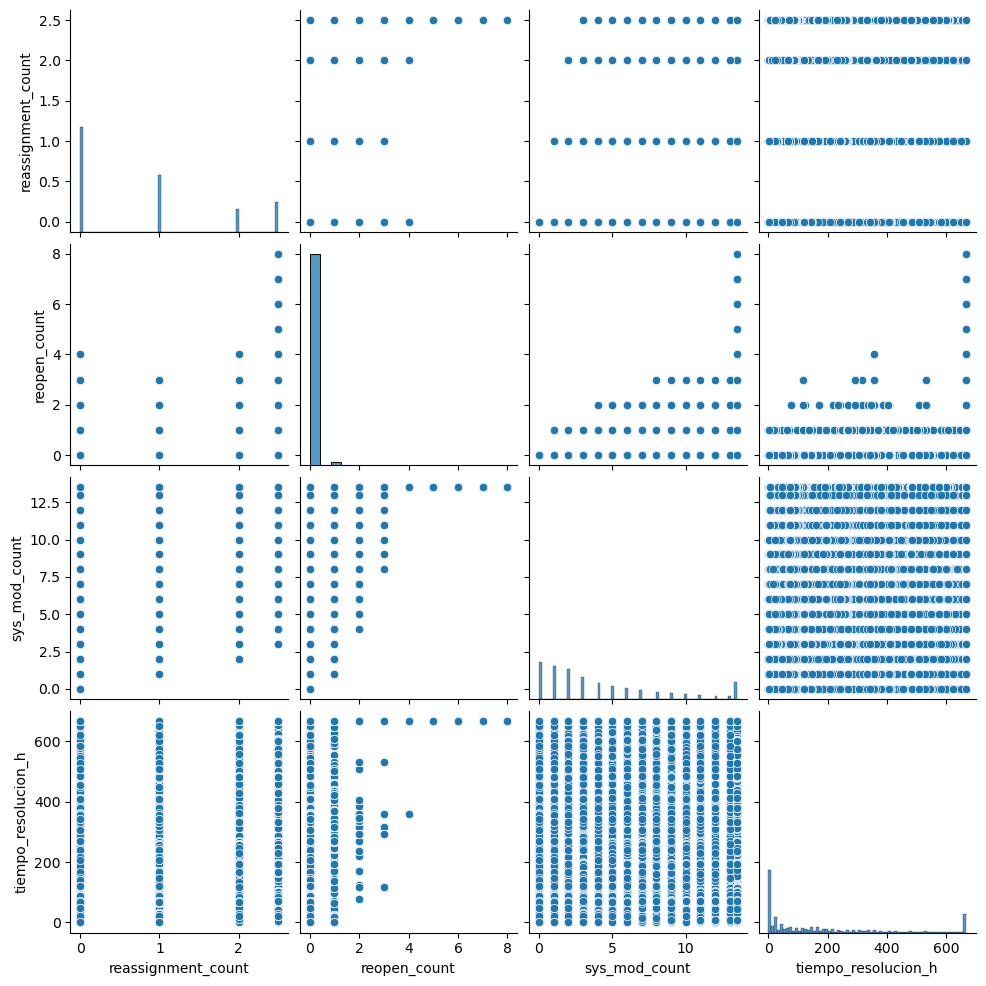

In [26]:
import seaborn as sns
%matplotlib inline
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
sns.pairplot(data[num_cols])

<Axes: >

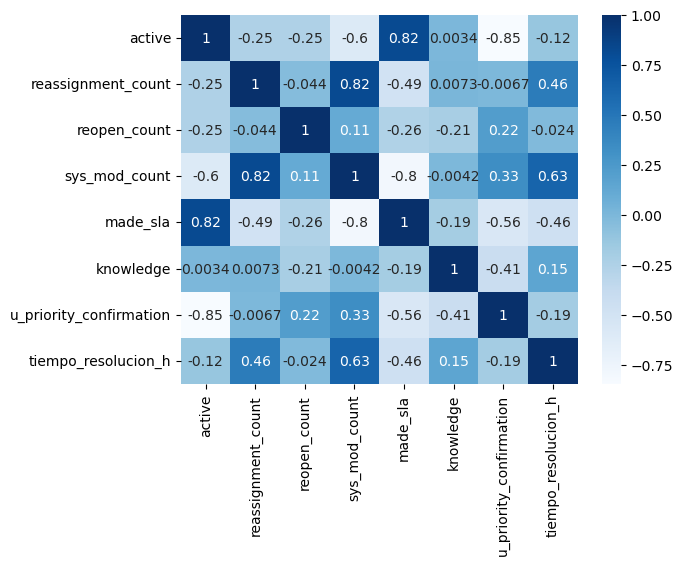

In [27]:
corr = data.corr(numeric_only=True)   
corrG = corr.corr()
sns.heatmap(corrG, cmap="Blues", annot=True)

/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


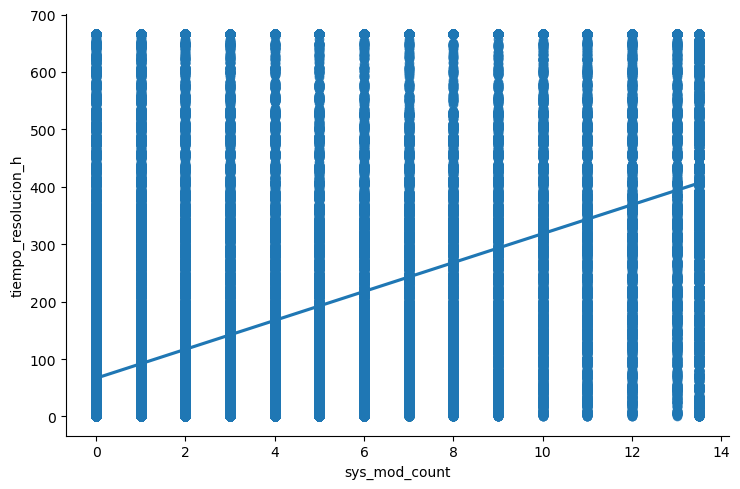

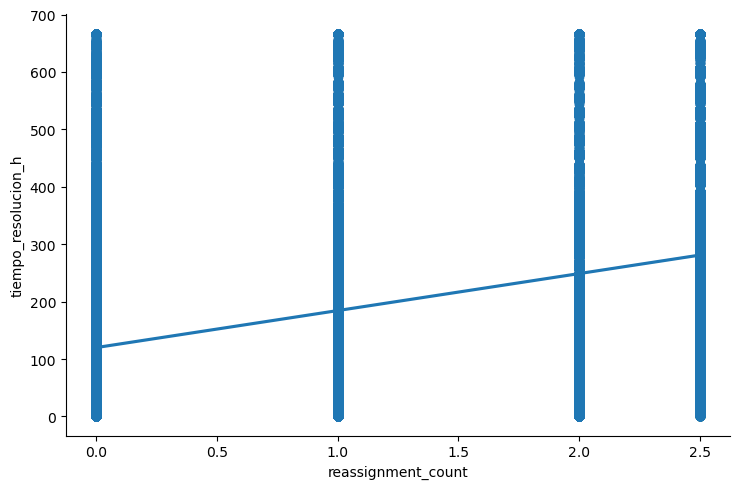

In [32]:
sns.lmplot(x="sys_mod_count", y="tiempo_resolucion_h", data=data, aspect=1.5)
sns.lmplot(x="reassignment_count", y="tiempo_resolucion_h", data=data, aspect=1.5)


<Axes: xlabel='made_sla', ylabel='reassignment_count'>

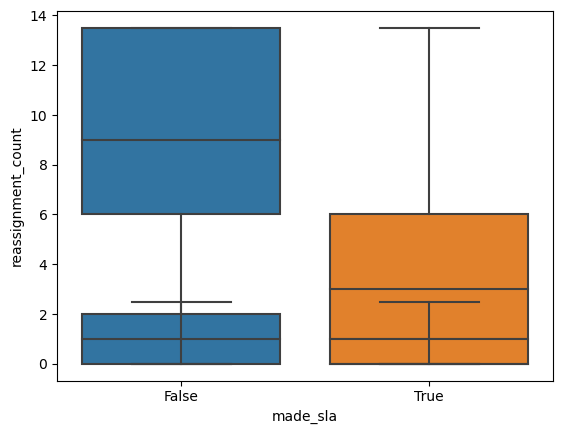

In [33]:
sns.boxplot(x="made_sla", y="sys_mod_count", data=data)
sns.boxplot(x="made_sla", y="reassignment_count", data=data)


/Users/sebastian/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


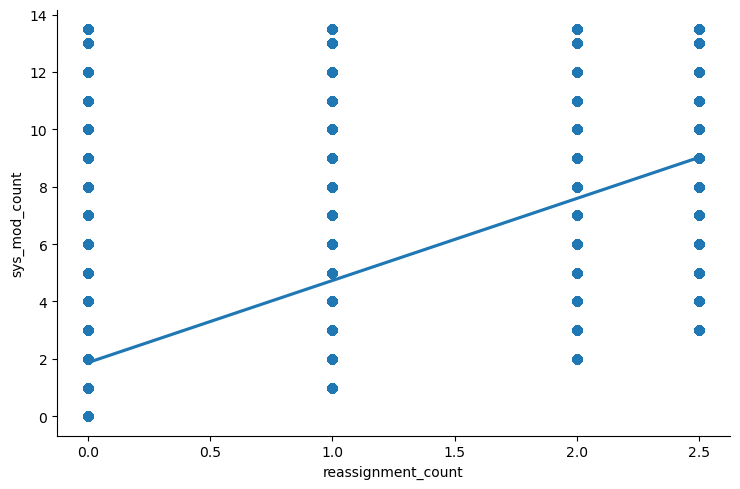

In [34]:
sns.lmplot(x="reassignment_count", y="sys_mod_count", data=data, aspect=1.5)

In [55]:
#Regresion 1 (tiempo_resolucion_h)
# nombres de características 
features = ['sys_mod_count','reassignment_count','made_sla']

# dataframe de características
X = data[features]
y = data['tiempo_resolucion_h']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
from sklearn.linear_model import LinearRegression

# crear el objeto del modelo
linreg = LinearRegression()
linreg.fit(X_train, y_train)

list(zip(features, linreg.coef_))
y_pred = linreg.predict(X_test)
from sklearn import metrics
import numpy as np
# mean absolute error
MAE = metrics.mean_absolute_error(y_test, y_pred)
# mean squared error
MSE = metrics.mean_squared_error(y_test, y_pred)
# root mean squared error
RMSE = np.sqrt(MSE)

print("MAE: ", MAE)
print("MSE: ", MSE)
print("RMSE: ", RMSE)

print("Intercepto:", linreg.intercept_)
R2 = linreg.score(X_test, y_test)
print("R²:", R2)

#Si existe relacion pero la capacidad predictiva es muy baja y con un error muy grande

MAE:  140.30954224403473
MSE:  34029.142554884784
RMSE:  184.46989606676962
Intercepto: 49.85639793772812
R²: 0.24480760640333554
